In [1]:
import pandas as pd

data = pd.read_csv("./step_delay_mapping.csv")

model_exec_times = pd.read_parquet("../edgedroid/data/resources/model_exec_times.parquet")
neuro = model_exec_times.groupby(["run_id", "neuroticism"], observed=True).count().reset_index().drop(columns=["ttf", "exec_time"]).set_index("run_id")

data = data.join(other=neuro, on="participant", how="left")
data = data.drop(columns=["start", "end", "duration"], errors="ignore")
data["participant"] = data["participant"].astype("category")
data["delay"] = pd.to_timedelta(data["delay"]).dt.total_seconds()
data["exec_time"] = pd.to_timedelta(data["exec_time"]).dt.total_seconds()
data

,participant,abs_seq,delay,block,block_seq,exec_time,neuroticism
0,134146,0,0.0,0,0,3.029,0.375
1,134146,1,0.0,1,0,4.004,0.375
2,134146,2,0.0,1,1,2.625,0.375
3,134146,3,0.0,1,2,4.680,0.375
4,134146,4,0.0,1,3,5.197,0.375
...,...,...,...,...,...,...,...
6755,137353,164,0.0,21,7,6.358,0.625
6756,137353,165,0.0,21,8,3.840,0.625
6757,137353,166,0.0,21,9,2.932,0.625
6758,137353,167,0.0,21,10,1.874,0.625


In [71]:
import numpy as np

def _block_seq(df: pd.DataFrame) -> pd.DataFrame:
    print(df)
    new_df = pd.DataFrame(index=df.index)
    block_len = len(df.index)
    new_df["block_seq"] = np.arange(block_len)
    new_df["block_len"] = block_len
    return new_df

def _shift(df: pd.DataFrame) -> pd.DataFrame:
    df["block_len"] = df[["block", "participant"]].groupby(["block"]).transform(lambda df: len(df.index))
    df.loc[~np.isin(df["block_len"], [4, 8, 12]), "block_len"] = np.nan
    df[["prev_delay", "prev_block", "prev_block_seq", "prev_block_len"]] = df[["delay", "block", "block_seq", "block_len"]].shift()
    df["prev_ttf"] = df["prev_delay"] * 1.5
    return df

data = data.groupby("participant", as_index=False).apply(_shift).droplevel(0)
data["prev_duration"] = pd.cut(data["prev_block_seq"] + 1, [-np.inf, 5, 9, np.inf], right=False)
data["prev_block_len"] = data["prev_block_len"].astype("category")
data

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_79588/1705082669.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.groupby("participant", as_index=False).apply(_shift).droplevel(0)


,participant,abs_seq,delay,block,block_seq,exec_time,neuroticism,block_len,prev_delay,prev_block,prev_block_seq,prev_block_len,prev_ttf,prev_duration
0,134146,0,0.0,0,0,3.029,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134146,1,0.0,1,0,4.004,0.375,8.0,0.0,0.0,0.0,NaN,0.0,"[-inf, 5.0)"
2,134146,2,0.0,1,1,2.625,0.375,8.0,0.0,1.0,0.0,8.0,0.0,"[-inf, 5.0)"
3,134146,3,0.0,1,2,4.680,0.375,8.0,0.0,1.0,1.0,8.0,0.0,"[-inf, 5.0)"
4,134146,4,0.0,1,3,5.197,0.375,8.0,0.0,1.0,2.0,8.0,0.0,"[-inf, 5.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,137353,164,0.0,21,7,6.358,0.625,12.0,0.0,21.0,6.0,12.0,0.0,"[5.0, 9.0)"
6756,137353,165,0.0,21,8,3.840,0.625,12.0,0.0,21.0,7.0,12.0,0.0,"[5.0, 9.0)"
6757,137353,166,0.0,21,9,2.932,0.625,12.0,0.0,21.0,8.0,12.0,0.0,"[9.0, inf)"
6758,137353,167,0.0,21,10,1.874,0.625,12.0,0.0,21.0,9.0,12.0,0.0,"[9.0, inf)"


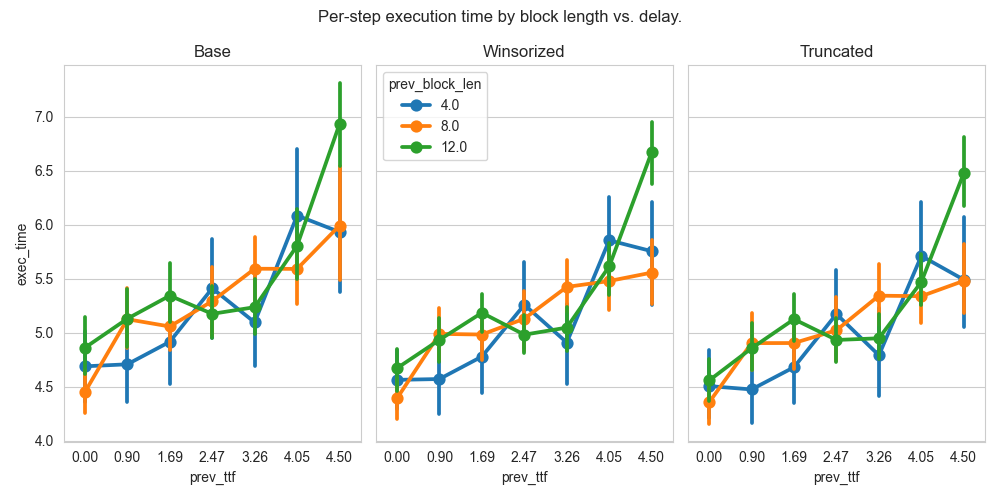

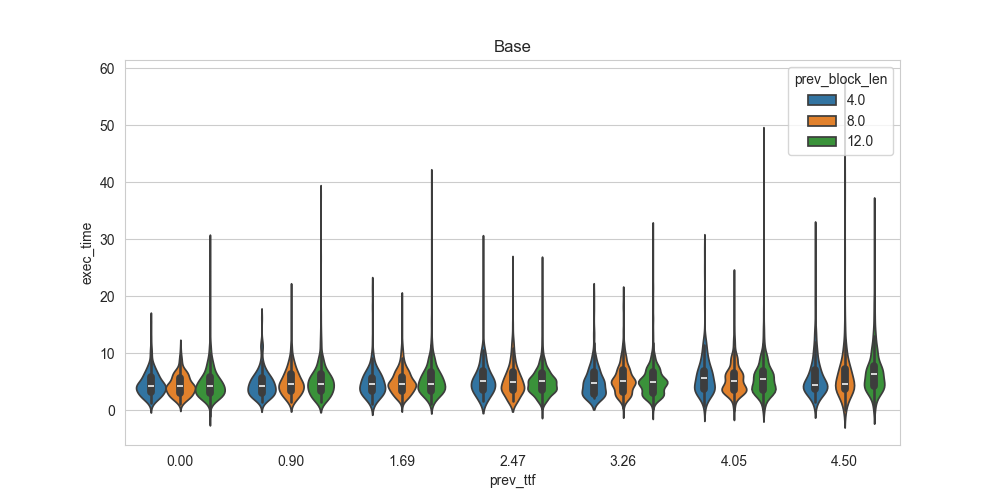

In [96]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import numpy as np
import numpy.typing as npt

ttfs = np.sort(data["prev_ttf"].dropna().unique())


def winsorize(arr: npt.ArrayLike | npt.NDArray, p: int = 5) -> int | float:
    low_bound = np.percentile(arr, p)
    high_bound = np.percentile(arr, 100 - p)
    arr[arr < low_bound] = low_bound
    arr[arr > high_bound] = high_bound
    return arr

def truncate(arr: npt.ArrayLike | npt.NDArray, p: int = 5) -> int | float:
    low_bound = np.percentile(arr, p)
    high_bound = np.percentile(arr, 100 - p)
    return np.copy(arr[np.logical_and(arr >= low_bound, arr <= high_bound)])

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", estimator="mean", ax=axes[0], legend=False)
axes[0].set_title("Base")

sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", estimator=lambda v: np.mean(winsorize(v)), ax=axes[1])
axes[1].set_title("Winsorized")

sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", estimator=lambda v: np.mean(truncate(v)), ax=axes[2], legend=False)
axes[2].set_title("Truncated")

axes[0].set_xticks(ticks=axes[0].get_xticks(), labels=[f"{t:0.2f}" for t in ttfs])

fig.suptitle("Per-step execution time by block length vs. delay.")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", ax=ax, legend=True)
ax.set_title("Base")
ax.set_xticks(ticks=axes[0].get_xticks(), labels=[f"{t:0.2f}" for t in ttfs])
plt.show()


# look at empirical distributions 

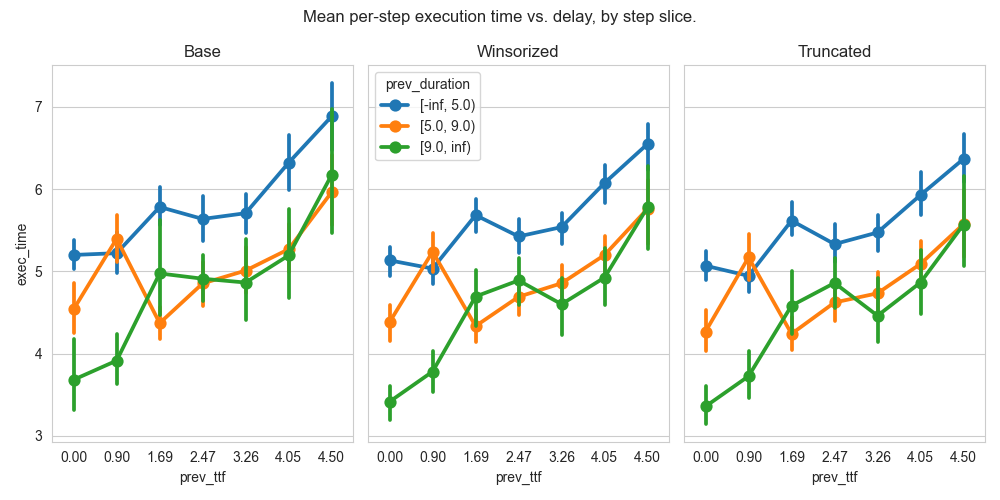

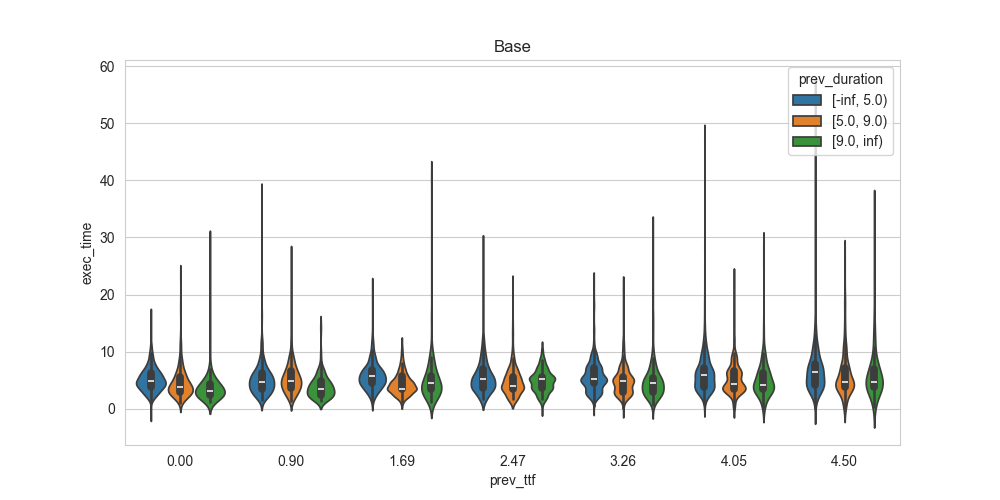

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", estimator="mean", ax=axes[0], legend=False)
axes[0].set_title("Base")

sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", estimator=winsorized_mean, ax=axes[1])
axes[1].set_title("Winsorized")

sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", estimator=truncated_mean, ax=axes[2], legend=False)
axes[2].set_title("Truncated")

axes[0].set_xticks(ticks=axes[0].get_xticks(), labels=[f"{t:0.2f}" for t in ttfs])

fig.suptitle("Mean per-step execution time vs. delay, by step slice.")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", ax=ax, legend=True)
ax.set_title("Base")
ax.set_xticks(ticks=axes[0].get_xticks(), labels=[f"{t:0.2f}" for t in ttfs])
plt.show()

# IQR cleanup

In [95]:
def aggregate_means(s: pd.Series) -> pd.Series:
    if len(s.index) < 4:
        return pd.Series({"mean": np.nan, "mean_winsorized": np.nan, "mean_truncated": np.nan})
    
    print(s[:4])
    raise Exception()
    
    ns = pd.Series()
    ns["mean"] = s.mean()
    ns["mean_winsorized"] = np.mean(winsorize(s.to_numpy()))
    ns["mean_truncated"] = np.mean(truncate(s.to_numpy()))
    return ns

def shift_blocks(df: pd.DataFrame) -> pd.DataFrame:
    df[["prev_block", "prev_block_delay"]] = df[["block", "delay"]].shift()
    short_blocks = df["prev_block_delay"] <= 1.65
    df["prev_block_cat"] = "long"
    df.loc[short_blocks, "prev_block_cat"] = "short"
    df["prev_block_cat"] = df["prev_block_cat"].astype("category")
    return df

(
    data[["participant", "block", "block_len", "delay"]]
    .groupby(["participant", "block", "block_len", "delay"])
    
)


,participant,block,block_len,delay
0,134146,0,NaN,0.0
1,134146,1,8.0,0.0
2,134146,1,8.0,0.0
3,134146,1,8.0,0.0
4,134146,1,8.0,0.0
...,...,...,...,...
6755,137353,21,12.0,0.0
6756,137353,21,12.0,0.0
6757,137353,21,12.0,0.0
6758,137353,21,12.0,0.0


In [ ]:
fg = sns.catplot(data=mean_exec_time_block, x="delay",y="exec_time", hue="prev_block_cat", kind="bar")